A notebook for implementing exploratory statistical analysis on celebrity chef recipes' difficulty and durations.

#0. Setup

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
from scipy import stats

Loading in Mongo data:

In [4]:
client = pymongo.MongoClient()
chefs = client.chefs_db
recipes = client.chefs_db.celebrity_recipes

In [5]:
## Some basic exploration
print "Count of number of documents:", recipes.count()
print "Keys in one example document:", recipes.find_one().keys()
print "One example document:", recipes.find_one()

Count of number of documents: 8135
Keys in one example document: [u'total_time', u'cook_time', u'title', u'difficulty_level', u'ingredients', u'page_link', u'yield', u'chef', u'img_link', u'course', u'inactive_time', u'prep_time', u'directions', u'_id']
One example document: {u'total_time': 5, u'cook_time': nan, u'title': u'Vanilla Frosting', u'difficulty_level': u'Easy', u'ingredients': [u' butter', u'powdered sugar', u'milk', u'vanilla extract'], u'page_link': u'http://www.foodnetwork.com/recipes/giada-de-laurentiis/vanilla-frosting-recipe.html', u'yield': u'about 1 pound (enough for 12 cupcakes)', u'chef': u'Giada De Laurentiis', u'img_link': u'http://foodnetwork.sndimg.com/content/dam/images/food/fullset/2011/12/12/3/0170936_vanilla-frosting_s4x3.jpg.rend.sni12col.landscape.jpeg', u'course': u'Desserts', u'inactive_time': nan, u'prep_time': 5, u'directions': u'nan', u'_id': ObjectId('56ef50cffdb32c0327e5a24f')}


In [7]:
recipes.find_one()['ingredients']

[u' butter', u'powdered sugar', u'milk', u'vanilla extract']

#1. Histograms and exploratory statistics
a) Difficulty across all chefs

b) Difficulty for each chef individually

c) Durations across all chefs

d) Durations for each chef individually

Difficulty: Easy, Intermediate, Advanced, Expert

In [8]:
levels_all_chefs = []
levels_by_chef = defaultdict(list)
for recipe in tqdm(recipes.find({}, {"difficulty_level": 1, "chef": 1, "_id": 0})):
    if recipe["difficulty_level"] != u'nan':
        levels_all_chefs.append(recipe["difficulty_level"])
        levels_by_chef[recipe["chef"]].append(recipe["difficulty_level"])

**Difficulty distribution, all chefs:**

In [6]:
Counter(levels_all_chefs)

Counter({u'Easy': 5969, u'Intermediate': 1672, u'Advanced': 84, u'Expert': 3})

All Chefs


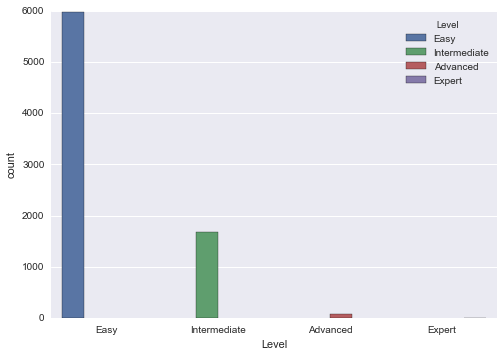

In [8]:
levels_all_df = pd.DataFrame(levels_all_chefs, columns=["Level"])
sns.countplot(x="Level", hue="Level", data=levels_all_df, 
              order=["Easy", "Intermediate", "Advanced", "Expert"])
print "All Chefs"
sns.plt.show()

**Difficulty distributions, by chef:**

In [50]:
for chef, levels in levels_by_chef.items():
    print chef, Counter(levels)

Giada De Laurentiis Counter({u'Easy': 981, u'Intermediate': 219, u'Advanced': 2})
Alton Brown Counter({u'Easy': 416, u'Intermediate': 182, u'Advanced': 17, u'Expert': 1})
Trisha Yearwood Counter({u'Easy': 274, u'Intermediate': 31})
Guy Fieri Counter({u'Easy': 586, u'Intermediate': 199, u'Advanced': 7, u'Expert': 1})
Valerie Bertinelli Counter({u'Easy': 93, u'Intermediate': 15})
Marcela Valladolid Counter({u'Easy': 279, u'Intermediate': 26, u'Advanced': 1})
Ina Garten Counter({u'Easy': 755, u'Intermediate': 166, u'Advanced': 4})
Ree Drummond Counter({u'Easy': 669, u'Intermediate': 57})
Bobby Flay Counter({u'Easy': 937, u'Intermediate': 415, u'Advanced': 19})
Robert Irvine Counter({u'Easy': 528, u'Intermediate': 304, u'Advanced': 32, u'Expert': 1})
Duff Goldman Counter({u'Easy': 18, u'Intermediate': 16, u'Advanced': 2})
Sunny Anderson Counter({u'Easy': 433, u'Intermediate': 42})


Giada De Laurentiis


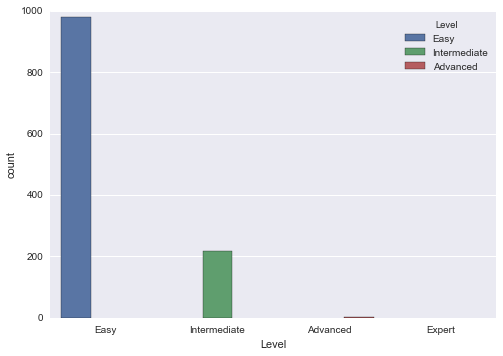

Alton Brown


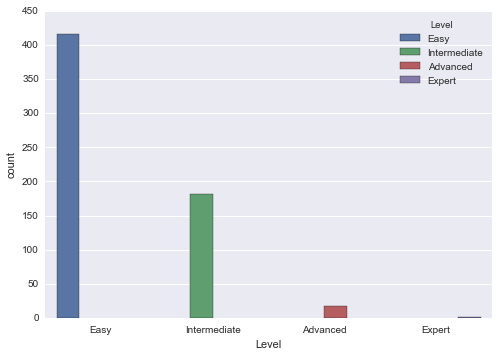

Trisha Yearwood


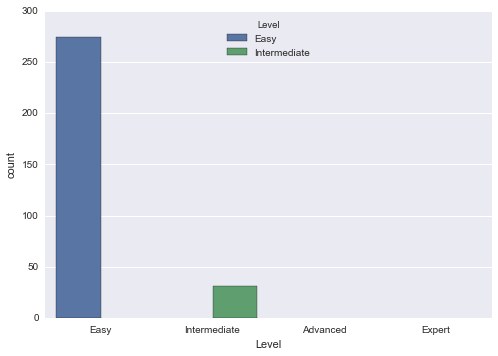

Guy Fieri


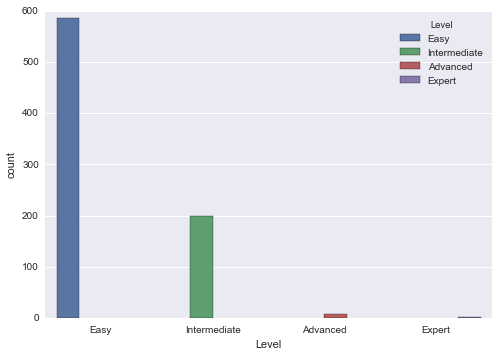

Valerie Bertinelli


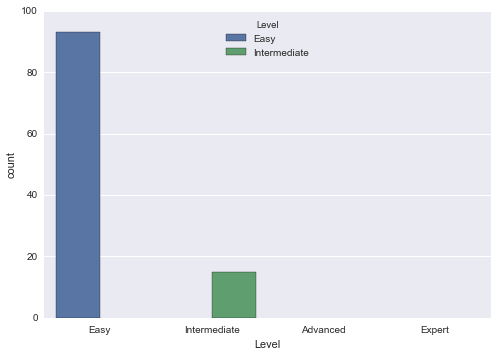

Marcela Valladolid


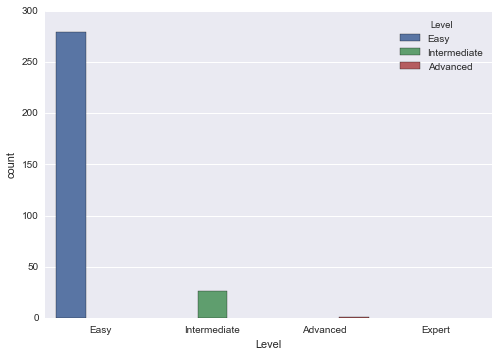

Ina Garten


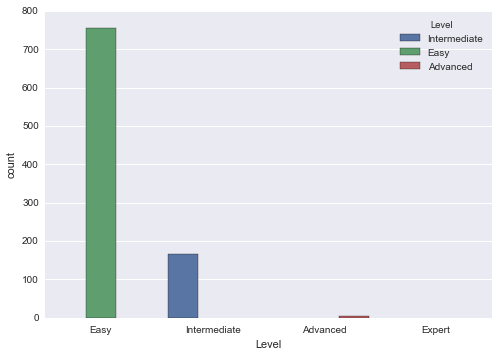

Ree Drummond


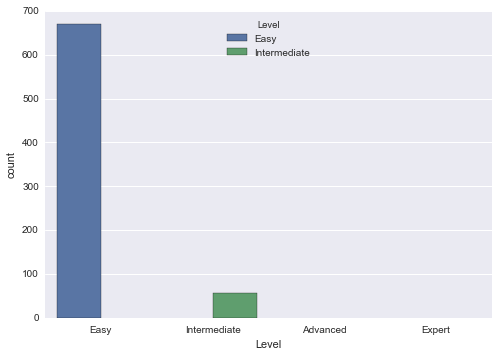

Bobby Flay


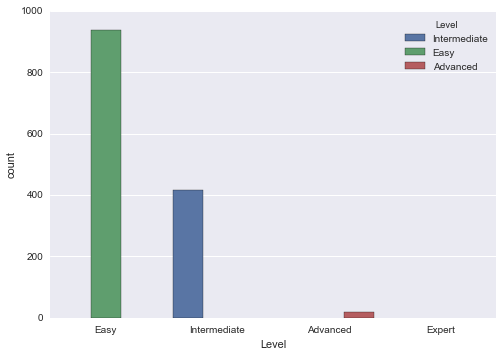

Robert Irvine


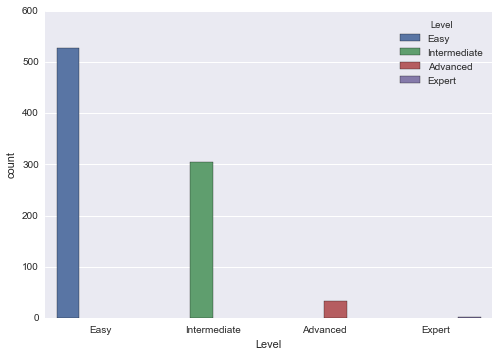

Duff Goldman


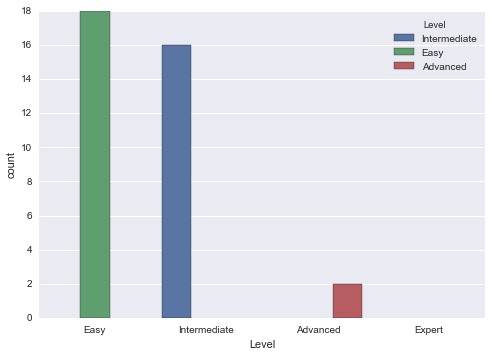

Sunny Anderson


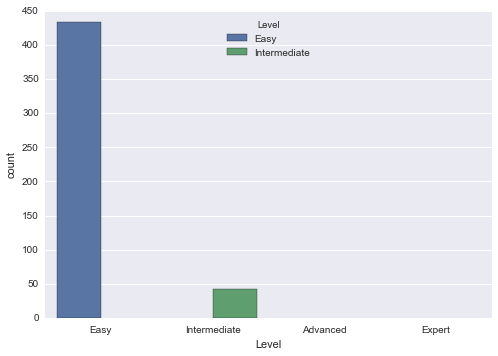

In [9]:
for chef, levels in levels_by_chef.items():
    levels_chef_df = pd.DataFrame(levels, columns=["Level"])
    sns.countplot(x="Level", hue="Level", data=levels_chef_df, 
                  order=["Easy", "Intermediate", "Advanced", "Expert"])
    print chef
    sns.plt.show()

Recipe durations in minutes: prep, inactive, cook, and total times

Originally, the data was quite right-skewed:
```
# First, naive pass:
durations_all_chefs = defaultdict(list)
durations_by_chef = defaultdict(lambda: defaultdict(list))
for recipe in tqdm(recipes.find({}, {u'chef':1, u'total_time':1, u'cook_time':1, 
                                     u'inactive_time':1, u'prep_time':1, '_id': 0})):
    if type(recipe[u'total_time']) == int:
        durations_all_chefs[u'total_time'].append(recipe[u'total_time'])
        durations_by_chef[recipe[u'chef']][u'total_time'].append(recipe[u'total_time'])
    if type(recipe[u'prep_time']) == int:
        durations_all_chefs[u'prep_time'].append(recipe[u'prep_time'])
        durations_by_chef[recipe[u'chef']][u'prep_time'].append(recipe[u'prep_time'])
    if type(recipe[u'inactive_time']) == int:
        durations_all_chefs[u'inactive_time'].append(recipe[u'inactive_time'])
        durations_by_chef[recipe[u'chef']][u'inactive_time'].append(recipe[
                                                                    u'inactive_time'])
    if type(recipe[u'cook_time']) == int:
        durations_all_chefs[u'cook_time'].append(recipe[u'cook_time'])
        durations_by_chef[recipe[u'chef']][u'cook_time'].append(recipe[u'cook_time'])
```

We can cut down on the skewness, as well as the variance in the data, by limiting the range of durations we consider. From previous exploration, based on a naive version of `durations_all_chefs` that did not take into account particular ranges, we can discern (by sorting the times) it to be advisable to limit time ranges in the following ways:
- Limit recipes to <= 600 mintues (10hrs) of total time.
- Limit recipes to <= 90 mintues (1.5hrs) of prep time.
- Limit recipes to <= 720 mintues (12hrs) of inactive time.
- Limit recipes to <= 180 mintues (3hrs) of cook time.

In [9]:
durations_all_chefs = defaultdict(list)
durations_by_chef = defaultdict(lambda: defaultdict(list))
for recipe in tqdm(recipes.find({}, {u'chef':1, u'total_time':1, u'cook_time':1, 
                                     u'inactive_time':1, u'prep_time':1, '_id': 0})):
    if type(recipe[u'total_time']) == int: # and recipe[u'total_time'] <= 600:
        durations_all_chefs[u'total_time'].append(recipe[u'total_time'])
        durations_by_chef[recipe[u'chef']][u'total_time'].append(recipe[u'total_time'])
    if type(recipe[u'prep_time']) == int: # and recipe[u'prep_time'] <= 90:
        durations_all_chefs[u'prep_time'].append(recipe[u'prep_time'])
        durations_by_chef[recipe[u'chef']][u'prep_time'].append(recipe[u'prep_time'])
    if type(recipe[u'inactive_time']) == int: # and recipe[u'inactive_time'] <= 720:
        durations_all_chefs[u'inactive_time'].append(recipe[u'inactive_time'])
        durations_by_chef[recipe[u'chef']][u'inactive_time'].append(recipe[u'inactive_time'])
    if type(recipe[u'cook_time']) == int: # and recipe[u'cook_time'] <= 180:
        durations_all_chefs[u'cook_time'].append(recipe[u'cook_time'])
        durations_by_chef[recipe[u'chef']][u'cook_time'].append(recipe[u'cook_time'])

**Duration distributions, all chefs:**

In [4]:
len(durations_all_chefs['total_time'])

7707

In [147]:
len(durations_all_chefs['prep_time'])

7836

In [144]:
len(durations_all_chefs['cook_time'])

6639

In [145]:
len(durations_all_chefs['inactive_time'])

3185

Exploratory statistics for all chefs: mean, median, mode, standard deviation

In [148]:
#Total times all chefs
ttac_mean = np.mean(durations_all_chefs['total_time'])
ttac_median = np.median(durations_all_chefs['total_time'])
ttac_mode =  stats.mode(durations_all_chefs['total_time'])
ttac_std = np.std(durations_all_chefs['total_time'])

#Prep times all chefs
ptac_mean = np.mean(durations_all_chefs['prep_time'])
ptac_median = np.median(durations_all_chefs['prep_time'])
ptac_mode =  stats.mode(durations_all_chefs['prep_time'])
ptac_std = np.std(durations_all_chefs['prep_time'])

#Cook times all chefs
ctac_mean = np.mean(durations_all_chefs['cook_time'])
ctac_median = np.median(durations_all_chefs['cook_time'])
ctac_mode =  stats.mode(durations_all_chefs['cook_time'])
ctac_std = np.std(durations_all_chefs['cook_time'])

#Inactive times all chefs
itac_mean = np.mean(durations_all_chefs['inactive_time'])
itac_median = np.median(durations_all_chefs['inactive_time'])
itac_mode =  stats.mode(durations_all_chefs['inactive_time'])
itac_std = np.std(durations_all_chefs['inactive_time'])

In [149]:
print 'Total times all chefs:'
print 'mean:', ttac_mean 
print 'median:', ttac_median
print 'mode:', ttac_mode
print 'standard deviation:', ttac_std
print '\n'

print 'Prep times all chefs:'
print 'mean:', ptac_mean 
print 'median:', ptac_median
print 'mode:', ptac_mode
print 'standard deviation:', ptac_std
print '\n'

print 'Cook times all chefs:'
print 'mean:', ctac_mean 
print 'median:', ctac_median
print 'mode:', ctac_mode
print 'standard deviation:', ctac_std
print '\n'

print 'Inactive times all chefs:'
print 'mean:', itac_mean 
print 'median:', itac_median
print 'mode:', itac_mode
print 'standard deviation:', itac_std

Total times all chefs:
mean: 82.4035292591
median: 55.0
mode: (array([30]), array([ 432.]))
standard deviation: 92.4303622888


Prep times all chefs:
mean: 18.8309086269
median: 15.0
mode: (array([10]), array([ 1640.]))
standard deviation: 12.7798283039


Cook times all chefs:
mean: 33.2324145203
median: 25.0
mode: (array([10]), array([ 815.]))
standard deviation: 30.7732510229


Inactive times all chefs:
mean: 91.3783359498
median: 30.0
mode: (array([30]), array([ 425.]))
standard deviation: 135.526594452


The data still appears to be right-skewed, though not as extremely as it had been with those most extreme outliers. This skewness affects the mean as well as standard deviation. Plotting histograms affords a better look:

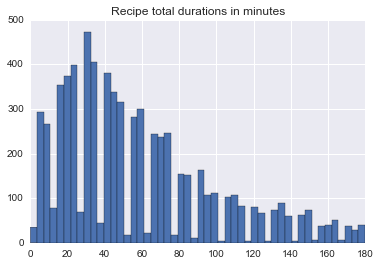

In [151]:
plt.title('Recipe total durations in minutes')
plt.hist(durations_all_chefs['total_time'], bins=50, range=(0,180)); 

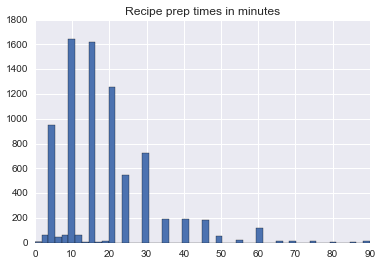

In [152]:
plt.title('Recipe prep times in minutes')
plt.hist(durations_all_chefs['prep_time'], bins=50, range=(0,90)); 

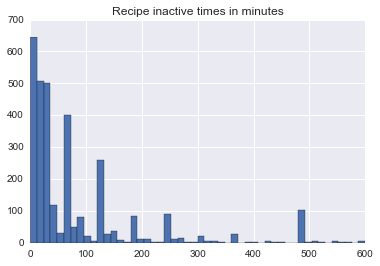

In [153]:
plt.title('Recipe inactive times in minutes')
plt.hist(durations_all_chefs['inactive_time'], bins=50, range=(0,600));

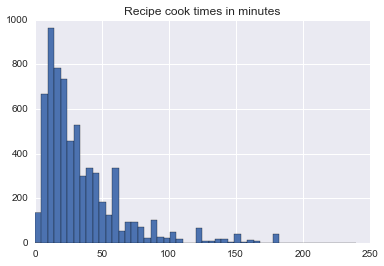

In [156]:
plt.title('Recipe cook times in minutes')
plt.hist(durations_all_chefs['cook_time'], bins=50, range=(0,240));

Here are the raw numbers, revealing that prep times suffer the most from skew, although variance is highest for cook times. Looks like there may be further outliers:

In [162]:
tavar = np.var(durations_all_chefs['total_time'])
taskew = stats.skew(durations_all_chefs['total_time'])
takurt = stats.kurtosis(durations_all_chefs['total_time'])

pavar = np.var(durations_all_chefs['prep_time'])
paskew = stats.skew(durations_all_chefs['prep_time'])
pakurt = stats.kurtosis(durations_all_chefs['prep_time'])

iavar = np.var(durations_all_chefs['inactive_time'])
iaskew = stats.skew(durations_all_chefs['inactive_time'])
iakurt = stats.kurtosis(durations_all_chefs['inactive_time'])

cavar = np.var(durations_all_chefs['cook_time'])
caskew = stats.skew(durations_all_chefs['cook_time'])
cakurt = stats.kurtosis(durations_all_chefs['cook_time'])

print 'Total times all chefs:'
print 'variance:', tavar
print 'skewness:', taskew
print 'kurtosis:', takurt
print '\n'

print 'Prep times all chefs:'
print 'variance:', pavar
print 'skewness:', paskew
print 'kurtosis:', pakurt
print '\n'

print 'Cook times all chefs:'
print 'variance:', iavar
print 'skewness:', iaskew
print 'kurtosis:', iakurt
print '\n'

print 'Inactive times all chefs:'
print 'variance:', cavar
print 'skewness:', caskew
print 'kurtosis:', cakurt

Total times all chefs:
variance: 8543.37187284
skewness: 2.72077508846
kurtosis: 8.85022350983


Prep times all chefs:
variance: 163.324011477
skewness: 1.75760112662
kurtosis: 4.38553052168


Cook times all chefs:
variance: 18367.4578038
skewness: 2.63145365237
kurtosis: 7.14250735716


Inactive times all chefs:
variance: 946.99297852
skewness: 2.05920779513
kurtosis: 5.13484458593


Also of interest are the modes:

In [158]:
print 'Total time mode:', ttac_mode
print 'Prep time mode:', ptac_mode
print 'Inactive time mode:', itac_mode
print 'Cook time mode:', ctac_mode

Total time mode: (array([30]), array([ 432.]))
Prep time mode: (array([10]), array([ 1640.]))
Inactive time mode: (array([30]), array([ 425.]))
Cook time mode: (array([10]), array([ 815.]))


It appears that 1/2-hour and 10-minute durations are quite popular. In particular, 10-minute prep times are wildly popular: *over 1 in 5 meals by a Food Network featured chef can be prepped in 10 minutes.*

**Duration distributions, by chef:**

Exploratory statistics by chef: mean, median, mode

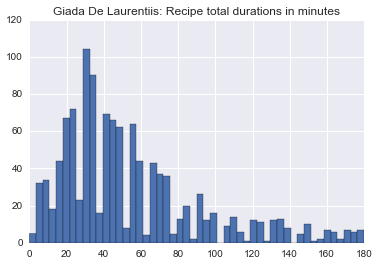

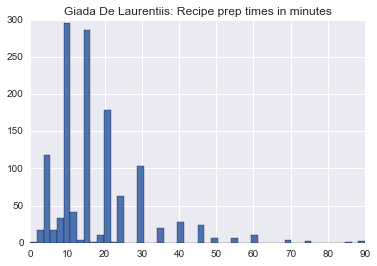

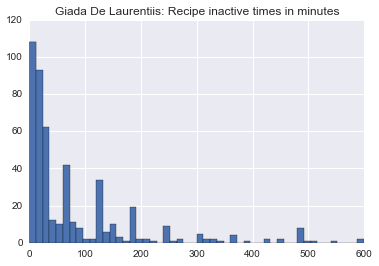

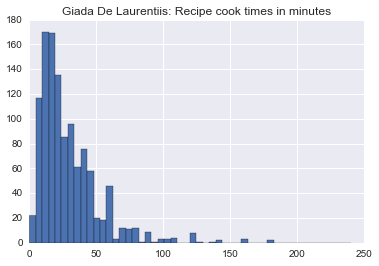

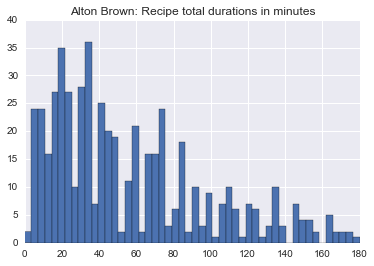

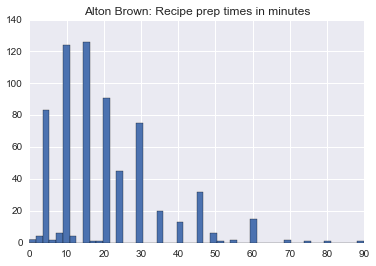

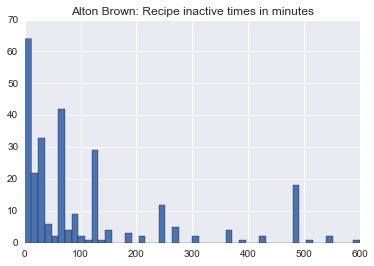

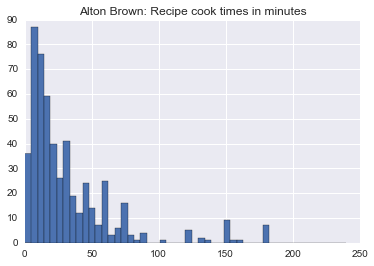

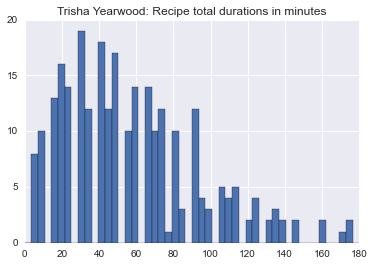

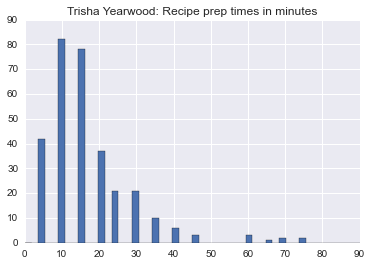

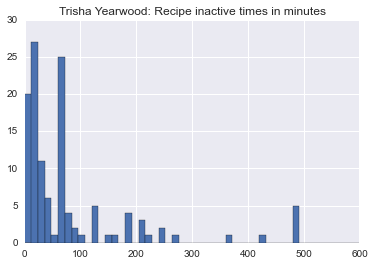

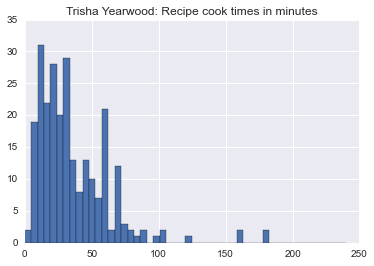

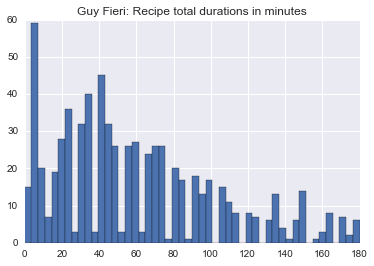

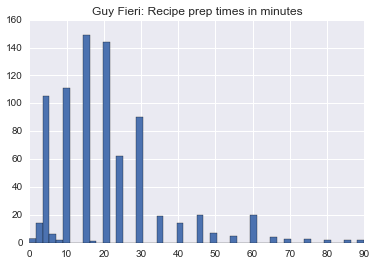

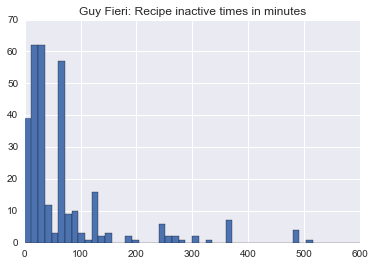

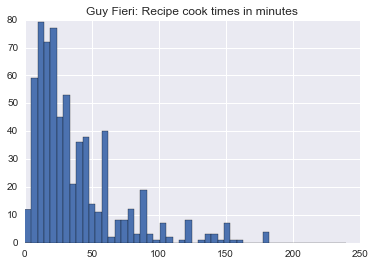

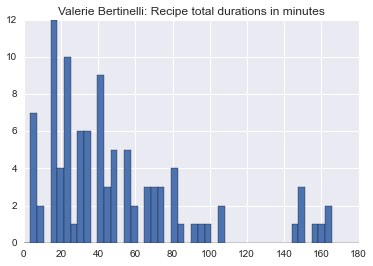

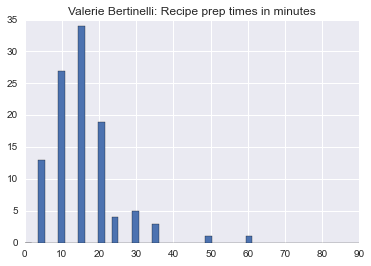

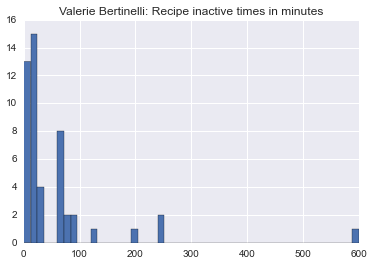

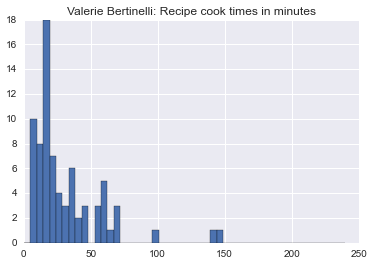

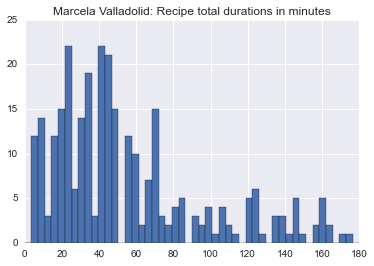

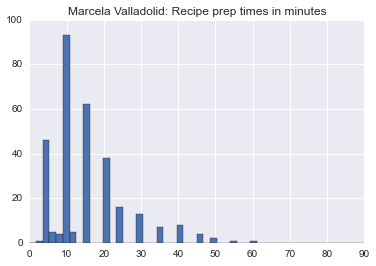

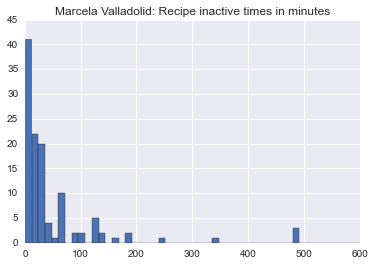

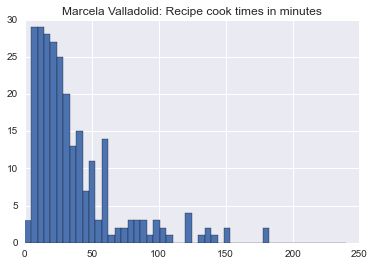

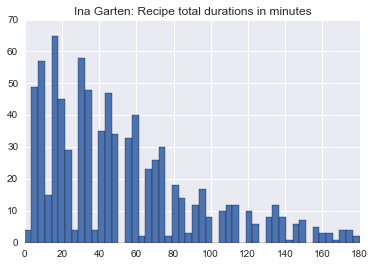

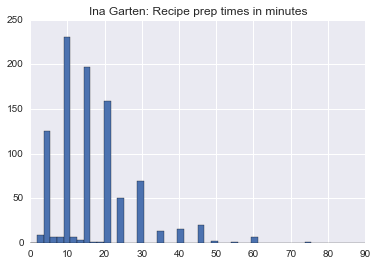

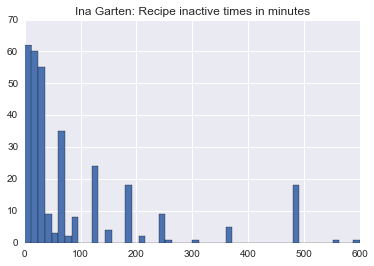

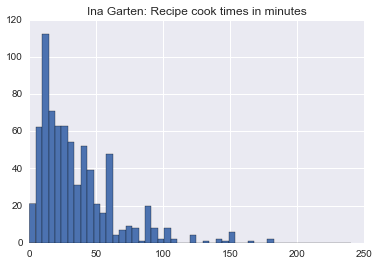

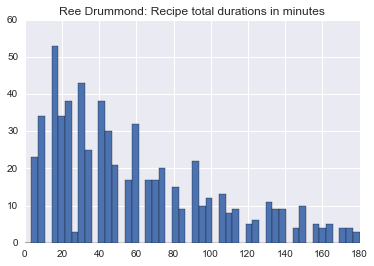

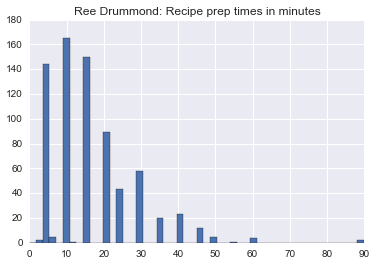

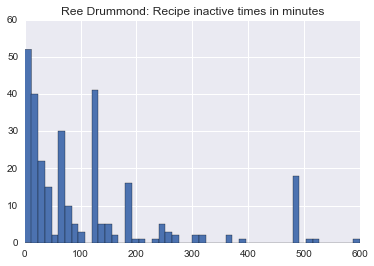

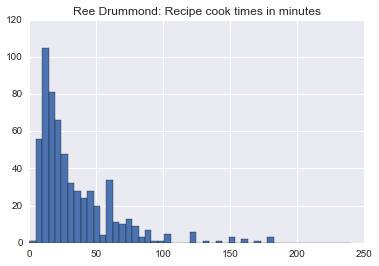

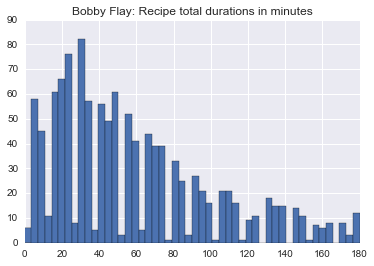

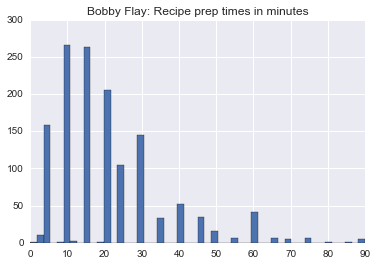

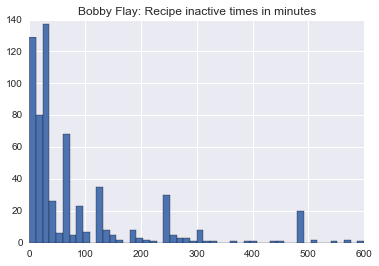

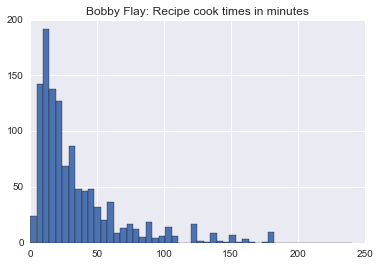

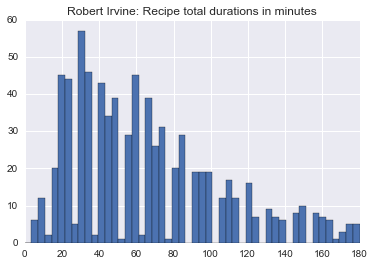

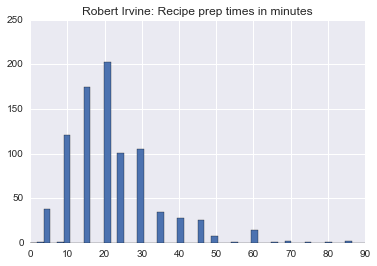

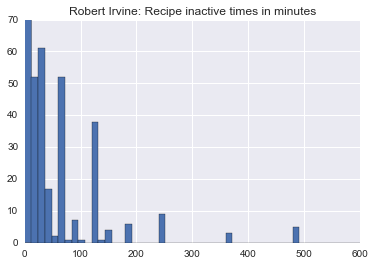

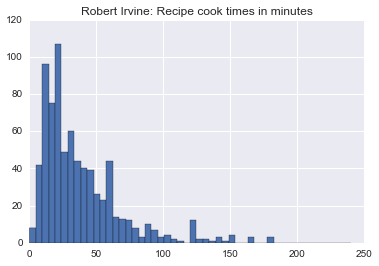

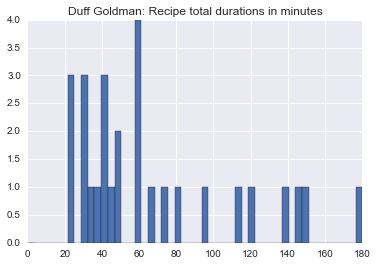

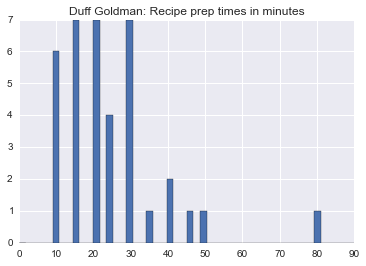

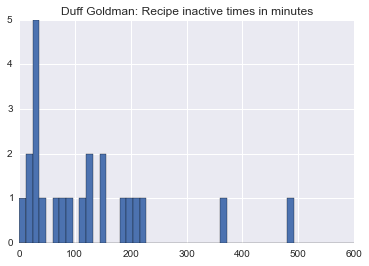

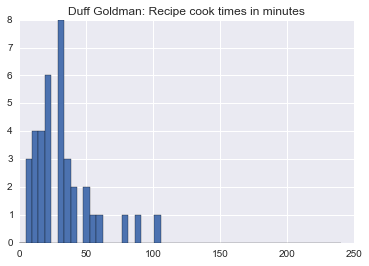

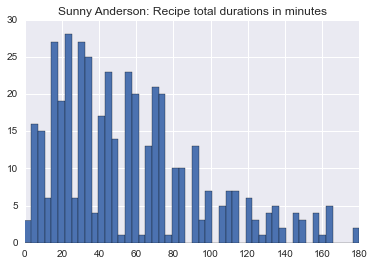

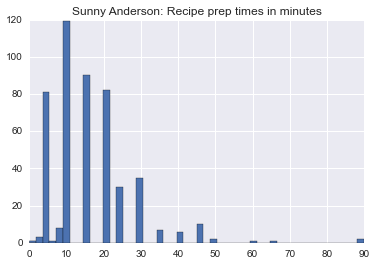

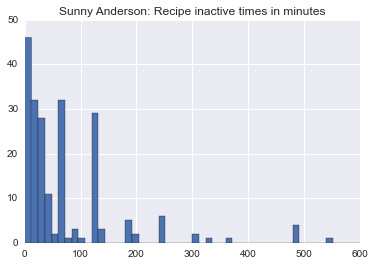

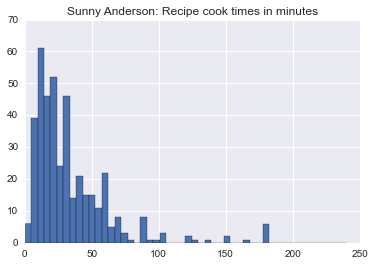

In [166]:
durations_by_chef_totals = {}

for chef, durations in durations_by_chef.items():
    chefdurations = {}
    
    #Total times by chef
    ttc_mean = np.mean(durations['total_time'])
    ttc_median = np.median(durations['total_time'])
    ttc_mode =  stats.mode(durations['total_time'])
    ttc_std = np.std(durations['total_time'])
    tvar = np.var(durations['total_time'])
    tskew = stats.skew(durations['total_time'])
    tkurt = stats.kurtosis(durations['total_time'])
    chefdurations['total_time_mean'] = ttc_mean 
    chefdurations['total_time_median'] = ttc_median
    chefdurations['total_time_mode'] = ttc_mode
    chefdurations['total_time_std'] = ttc_std
    chefdurations['total_time_variance'] = tvar
    chefdurations['total_time_skewness'] = tskew
    chefdurations['total_time_kurtosis'] = tkurt
    plt.title('%s: Recipe total durations in minutes' % chef)
    plt.hist(durations['total_time'], bins=50, range=(0,180));
    plt.show()
    
    #Prep times by chef
    ptc_mean = np.mean(durations['prep_time'])
    ptc_median = np.median(durations['prep_time'])
    ptc_mode =  stats.mode(durations['prep_time'])
    ptc_std = np.std(durations['prep_time'])
    pvar = np.var(durations['prep_time'])
    pskew = stats.skew(durations['prep_time'])
    pkurt = stats.kurtosis(durations['prep_time'])
    chefdurations['prep_time_mean'] = ptc_mean 
    chefdurations['prep_time_median'] = ptc_median
    chefdurations['prep_time_mode'] = ptc_mode
    chefdurations['prep_time_std'] = ptc_std
    chefdurations['prep_time_variance'] = pvar
    chefdurations['prep_time_skewness'] = pskew
    chefdurations['prep_time_kurtosis'] = pkurt
    plt.title('%s: Recipe prep times in minutes' % chef)
    plt.hist(durations['prep_time'], bins=50, range=(0,90));
    plt.show()

    #Inactive times by chef 
    itc_mean = np.mean(durations['inactive_time'])
    itc_median = np.median(durations['inactive_time'])
    itc_mode =  stats.mode(durations['inactive_time'])
    itc_std = np.std(durations['inactive_time'])
    ivar = np.var(durations['inactive_time'])
    iskew = stats.skew(durations['inactive_time'])
    ikurt = stats.kurtosis(durations['inactive_time'])
    chefdurations['inactive_time_mean'] = itc_mean 
    chefdurations['inactive_time_median'] = itc_median
    chefdurations['inactive_time_mode'] = itc_mode
    chefdurations['inactive_time_std'] = itc_std
    chefdurations['inactive_time_variance'] = ivar
    chefdurations['inactive_time_skewness'] = iskew
    chefdurations['inactive_time_kurtosis'] = ikurt
    plt.title('%s: Recipe inactive times in minutes' % chef)
    plt.hist(durations['inactive_time'], bins=50, range=(0,600));
    plt.show()
   
    #Cook times by chef 
    ctc_mean = np.mean(durations['cook_time'])
    ctc_median = np.median(durations['cook_time'])
    ctc_mode =  stats.mode(durations['cook_time'])
    ctc_std = np.std(durations['cook_time'])
    cvar = np.var(durations['cook_time'])
    cskew = stats.skew(durations['cook_time'])
    ckurt = stats.kurtosis(durations['cook_time'])
    chefdurations['cook_time_mean'] = ctc_mean 
    chefdurations['cook_time_median'] = ctc_median
    chefdurations['cook_time_mode'] = ctc_mode
    chefdurations['cook_time_std'] = ctc_std
    chefdurations['cook_time_variance'] = cvar
    chefdurations['cook_time_skewness'] = cskew
    chefdurations['cook_time_kurtosis'] = ckurt
    plt.title('%s: Recipe cook times in minutes' % chef)
    plt.hist(durations['cook_time'], bins=50, range=(0,240));
    plt.show()
    
    durations_by_chef_totals[chef] = chefdurations

In [167]:
durations_by_chef_totals

{u'Alton Brown': {'cook_time_kurtosis': 5.811169840210985,
  'cook_time_mean': 31.062737642585553,
  'cook_time_median': 20.0,
  'cook_time_mode': (array([5]), array([ 57.])),
  'cook_time_skewness': 2.2957357866357104,
  'cook_time_std': 34.623585053182616,
  'cook_time_variance': 1198.7926419349708,
  'inactive_time_kurtosis': 2.296880657365543,
  'inactive_time_mean': 133.1443661971831,
  'inactive_time_median': 60.0,
  'inactive_time_mode': (array([60]), array([ 40.])),
  'inactive_time_skewness': 1.8044918558474068,
  'inactive_time_std': 181.39765555290742,
  'inactive_time_variance': 32905.109440091248,
  'prep_time_kurtosis': 2.298952833157033,
  'prep_time_mean': 20.218844984802431,
  'prep_time_median': 15.0,
  'prep_time_mode': (array([15]), array([ 126.])),
  'prep_time_skewness': 1.3953948450405897,
  'prep_time_std': 13.801484784347155,
  'prep_time_variance': 190.48098225256604,
  'total_time_kurtosis': 6.178415544433037,
  'total_time_mean': 93.16447368421052,
  'total_

In [165]:
for chef, durations in durations_by_chef.items():
    tvar = np.var(durations['total_time'])
    tskew = stats.skew(durations['total_time'])
    tkurt = stats.kurtosis(durations['total_time'])

    pvar = np.var(durations['prep_time'])
    pskew = stats.skew(durations['prep_time'])
    pkurt = stats.kurtosis(durations['prep_time'])

    ivar = np.var(durations['inactive_time'])
    iskew = stats.skew(durations['inactive_time'])
    ikurt = stats.kurtosis(durations['inactive_time'])

    cvar = np.var(durations['cook_time'])
    cskew = stats.skew(durations['cook_time'])
    ckurt = stats.kurtosis(durations['cook_time'])

    print chef, ': total times'
    print 'variance:', tvar
    print 'skewness:', tskew
    print 'kurtosis:', tkurt
    print '\n'

    print chef, ': prep times'
    print 'variance:', pvar
    print 'skewness:', pskew
    print 'kurtosis:', pkurt
    print '\n'

    print chef, ': cook times'
    print 'variance:', ivar
    print 'skewness:', iskew
    print 'kurtosis:', ikurt
    print '\n'

    print chef, ': inactive times'
    print 'variance:', cvar
    print 'skewness:', cskew
    print 'kurtosis:', ckurt
    print '\n'

Giada De Laurentiis : total times
variance: 6692.83201924
skewness: 3.00184135489
kurtosis: 11.0546570299


Giada De Laurentiis : prep times
variance: 139.092456132
skewness: 2.05326814408
kurtosis: 6.14932572001


Giada De Laurentiis : cook times
variance: 13859.5481493
skewness: 2.54110316615
kurtosis: 7.12476470597


Giada De Laurentiis : inactive times
variance: 569.790992432
skewness: 2.23671580649
kurtosis: 7.34439236747


Alton Brown : total times
variance: 12603.9466326
skewness: 2.42864483748
kurtosis: 6.17841554443


Alton Brown : prep times
variance: 190.480982253
skewness: 1.39539484504
kurtosis: 2.29895283316


Alton Brown : cook times
variance: 32905.1094401
skewness: 1.80449185585
kurtosis: 2.29688065737


Alton Brown : inactive times
variance: 1198.79264193
skewness: 2.29573578664
kurtosis: 5.81116984021


Trisha Yearwood : total times
variance: 9862.13376606
skewness: 2.65495363218
kurtosis: 7.56943115141


Trisha Yearwood : prep times
variance: 144.536515433
skewness:

Durations by chef: breakdown
- low: <=20 min (also tried 30 min; not as insightful)
- medium: 20-45 min (also tried 30-60 min)
- high: >45 min (also tried >60 min)

In [76]:
low_med_high_dur = {}
for chef, durations in durations_by_chef.items():
    chefdurations = {}
    low = [d for d in durations['prep_time'] if d <= 20]
    low = float(len(low))/float(len(durations['prep_time']))
    low = round(low, 2)
    med = [d for d in durations['prep_time'] if 20 < d <= 45]
    med = float(len(med))/float(len(durations['prep_time']))
    med = round(med, 2)
    high = [d for d in durations['prep_time'] if d > 45]
    high = float(len(high))/float(len(durations['prep_time']))
    high = round(high, 2)
    chefdurations['prep'] = (low, med, high)
    low = [d for d in durations['cook_time'] if d <= 20]
    low = float(len(low))/float(len(durations['cook_time']))
    low = round(low, 2)
    med = [d for d in durations['cook_time'] if 20 < d <= 45]
    med = float(len(med))/float(len(durations['cook_time']))
    med = round(med, 2)
    high = [d for d in durations['cook_time'] if d > 45]
    high = float(len(high))/float(len(durations['cook_time']))
    high = round(high, 2)
    chefdurations['cook'] = (low, med, high)
    low_med_high_dur[chef] = chefdurations

In [14]:
low_med_high_dur

{u'Alton Brown': {'cook': (0.52, 0.23, 0.25), 'prep': (0.67, 0.28, 0.06)},
 u'Bobby Flay': {'cook': (0.52, 0.25, 0.23), 'prep': (0.65, 0.26, 0.09)},
 u'Duff Goldman': {'cook': (0.45, 0.34, 0.21), 'prep': (0.54, 0.41, 0.05)},
 u'Giada De Laurentiis': {'cook': (0.52, 0.33, 0.15),
  'prep': (0.79, 0.19, 0.03)},
 u'Guy Fieri': {'cook': (0.44, 0.29, 0.27), 'prep': (0.67, 0.26, 0.07)},
 u'Ina Garten': {'cook': (0.44, 0.32, 0.24), 'prep': (0.81, 0.18, 0.01)},
 u'Marcela Valladolid': {'cook': (0.44, 0.3, 0.26),
  'prep': (0.83, 0.16, 0.02)},
 u'Ree Drummond': {'cook': (0.49, 0.26, 0.25), 'prep': (0.76, 0.21, 0.02)},
 u'Robert Irvine': {'cook': (0.41, 0.29, 0.3), 'prep': (0.62, 0.34, 0.04)},
 u'Sunny Anderson': {'cook': (0.48, 0.29, 0.23), 'prep': (0.8, 0.18, 0.01)},
 u'Trisha Yearwood': {'cook': (0.38, 0.31, 0.31), 'prep': (0.78, 0.2, 0.03)},
 u'Valerie Bertinelli': {'cook': (0.54, 0.23, 0.23),
  'prep': (0.85, 0.11, 0.04)}}

#2. Further analysis of difficulty and duration

**On difficulty:**

In [10]:
chefs_df = pd.DataFrame(columns=["# Recipes", "% Simple", "% Complex"])
for chef, levels in levels_by_chef.items():
    levels = Counter(levels)
    total = sum(levels.values())
    easy = float(levels["Easy"]) / float(total)
    intermediate = float(levels["Intermediate"]) / float(total)
    advanced = float(levels["Advanced"]) / float(total)
    expert = float(levels["Expert"]) / float(total)
    chef_df = pd.DataFrame({"# Recipes":[total], "% Simple": [easy], 
                            "% Complex": [intermediate+advanced+expert]})
    chef_df.index = [chef]
    chefs_df = chefs_df.append(chef_df)

In [11]:
chefs_df = chefs_df.sort_values("% Simple", ascending=False)

In [12]:
chefs_df

,# Recipes,% Complex,% Simple
Ree Drummond,726,0.078512,0.921488
Marcela Valladolid,306,0.088235,0.911765
Sunny Anderson,475,0.088421,0.911579
Trisha Yearwood,305,0.101639,0.898361
Valerie Bertinelli,108,0.138889,0.861111
Ina Garten,925,0.183784,0.816216
Giada De Laurentiis,1202,0.183860,0.816140
Guy Fieri,793,0.261034,0.738966
Bobby Flay,1371,0.316557,0.683443
Alton Brown,616,0.324675,0.675325


In [145]:
index = tuple([u'Ree Drummond', u'Marcela Valladolid',  u'Sunny Anderson', u'Trisha Yearwood',
              u'Valerie Bertinelli', u'Ina Garten', u'Giada De Laurentiis', u'Guy Fieri', 
              u'Bobby Flay', u'Alton Brown', u'Robert Irvine',  u'Duff Goldman'])

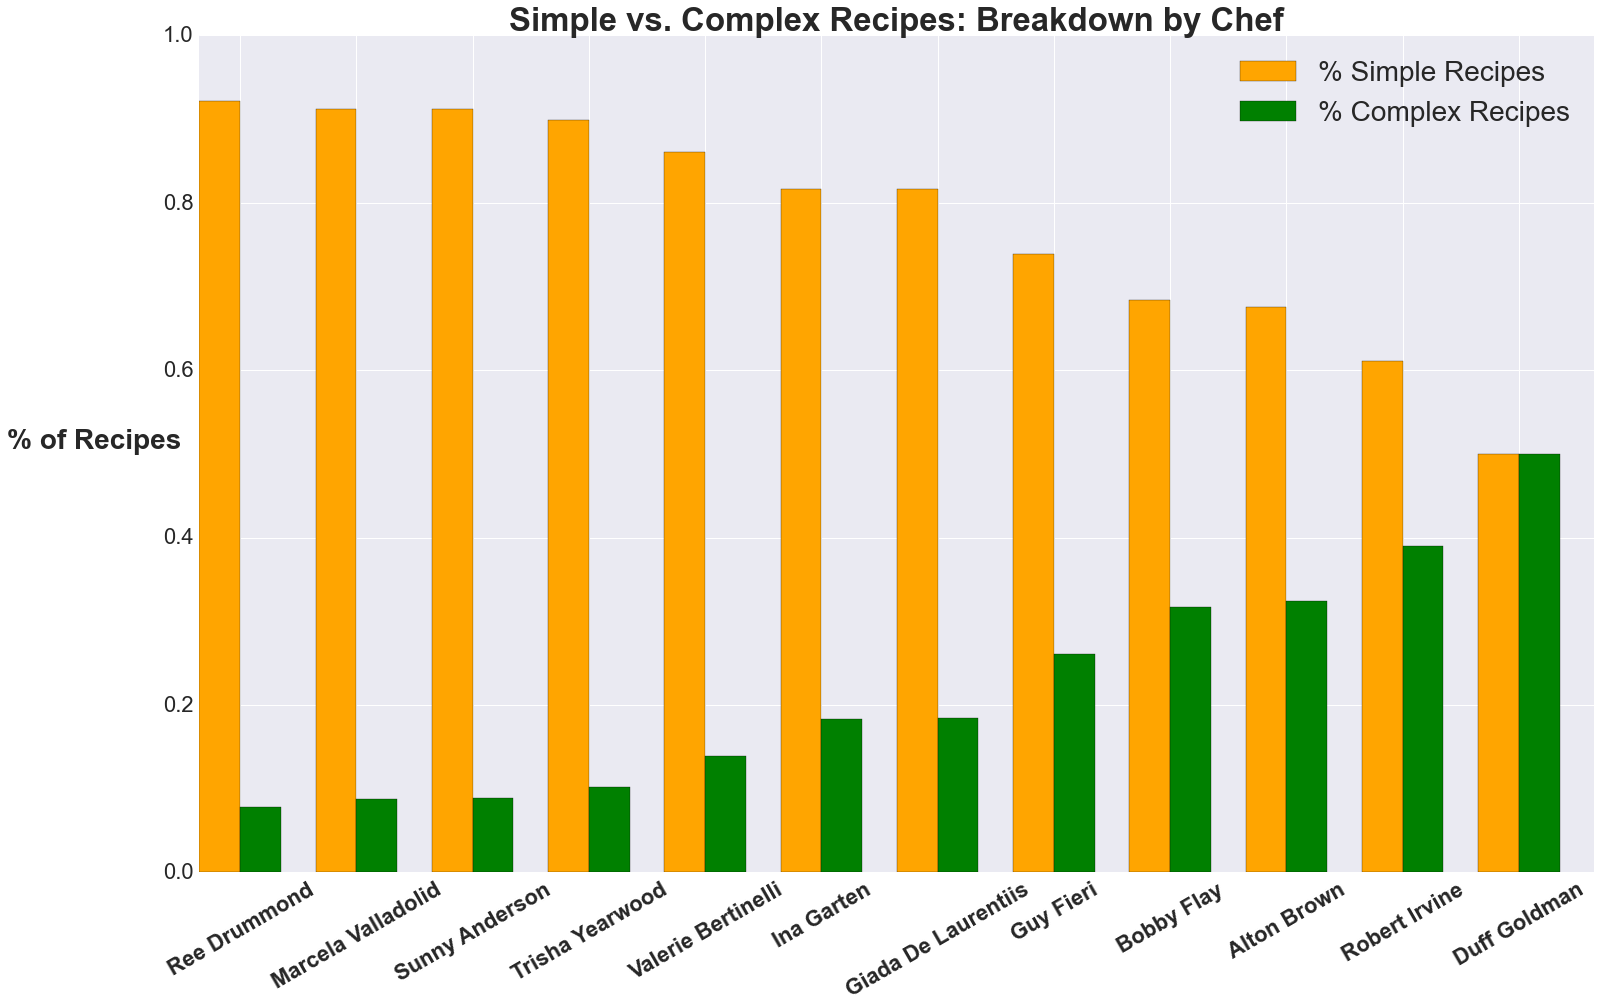

In [13]:
ind = np.arange(12)  
width = 0.35   
fig, ax = plt.subplots(figsize=(25, 15))
rects1 = ax.bar(ind, chefs_df["% Simple"], width, color='orange')
rects2 = ax.bar(ind + width, chefs_df["% Complex"], width, color='green')
namefont = {'weight' : 'bold',
        'size'   : 22}
axisfont = {'weight' : 'bold',
        'size'   : 28}
titlefont = {'weight' : 'bold',
        'size'   : 33}
ax.set_ylabel('% of Recipes', rotation=0, labelpad=70, **axisfont)
ax.tick_params(axis='y', labelsize=22)
ax.set_title('Simple vs. Complex Recipes: Breakdown by Chef', **titlefont)
ax.set_xticks(ind + width)
ax.set_xticklabels(chefs_df.index, rotation=30, **namefont)
ax.legend((rects1[0], rects2[0]), ('% Simple Recipes', '% Complex Recipes'), prop={'size':28})
plt.show()

In [ ]:
#ThatMomentWhenYouRealizeTheFoodNetworkIsSexist

**On duration:**

In [77]:
low_med_high_dur

{u'Alton Brown': {'cook': (0.52, 0.23, 0.25), 'prep': (0.67, 0.28, 0.06)},
 u'Bobby Flay': {'cook': (0.52, 0.25, 0.23), 'prep': (0.65, 0.26, 0.09)},
 u'Duff Goldman': {'cook': (0.45, 0.34, 0.21), 'prep': (0.54, 0.41, 0.05)},
 u'Giada De Laurentiis': {'cook': (0.52, 0.33, 0.15),
  'prep': (0.79, 0.19, 0.03)},
 u'Guy Fieri': {'cook': (0.44, 0.29, 0.27), 'prep': (0.67, 0.26, 0.07)},
 u'Ina Garten': {'cook': (0.44, 0.32, 0.24), 'prep': (0.81, 0.18, 0.01)},
 u'Marcela Valladolid': {'cook': (0.44, 0.3, 0.26),
  'prep': (0.83, 0.16, 0.02)},
 u'Ree Drummond': {'cook': (0.49, 0.26, 0.25), 'prep': (0.76, 0.21, 0.02)},
 u'Robert Irvine': {'cook': (0.41, 0.29, 0.3), 'prep': (0.62, 0.34, 0.04)},
 u'Sunny Anderson': {'cook': (0.48, 0.29, 0.23), 'prep': (0.8, 0.18, 0.01)},
 u'Trisha Yearwood': {'cook': (0.38, 0.31, 0.31), 'prep': (0.78, 0.2, 0.03)},
 u'Valerie Bertinelli': {'cook': (0.54, 0.23, 0.23),
  'prep': (0.85, 0.11, 0.04)}}

In [78]:
prep, cook = [],[]
for chef, durs in low_med_high_dur.items():  #create a stacked bar chart
    prep.append((durs['prep'][0], chef))
    cook.append((durs['cook'][0], chef))
chefs_prep = [entry[1] for entry in sorted(prep, reverse=True)]
chefs_cook = [entry[1] for entry in sorted(cook, reverse=True)]

In [79]:
prep_low, prep_mid, prep_high, cook_low, cook_mid, cook_high = [],[],[],[],[],[]
for chef in chefs_prep:
    prep_low.append(low_med_high_dur[chef]['prep'][0])
    prep_mid.append(low_med_high_dur[chef]['prep'][1])
    prep_high.append(low_med_high_dur[chef]['prep'][2])
    cook_low.append(low_med_high_dur[chef]['cook'][0])
    cook_mid.append(low_med_high_dur[chef]['cook'][1])
    cook_high.append(low_med_high_dur[chef]['cook'][2])

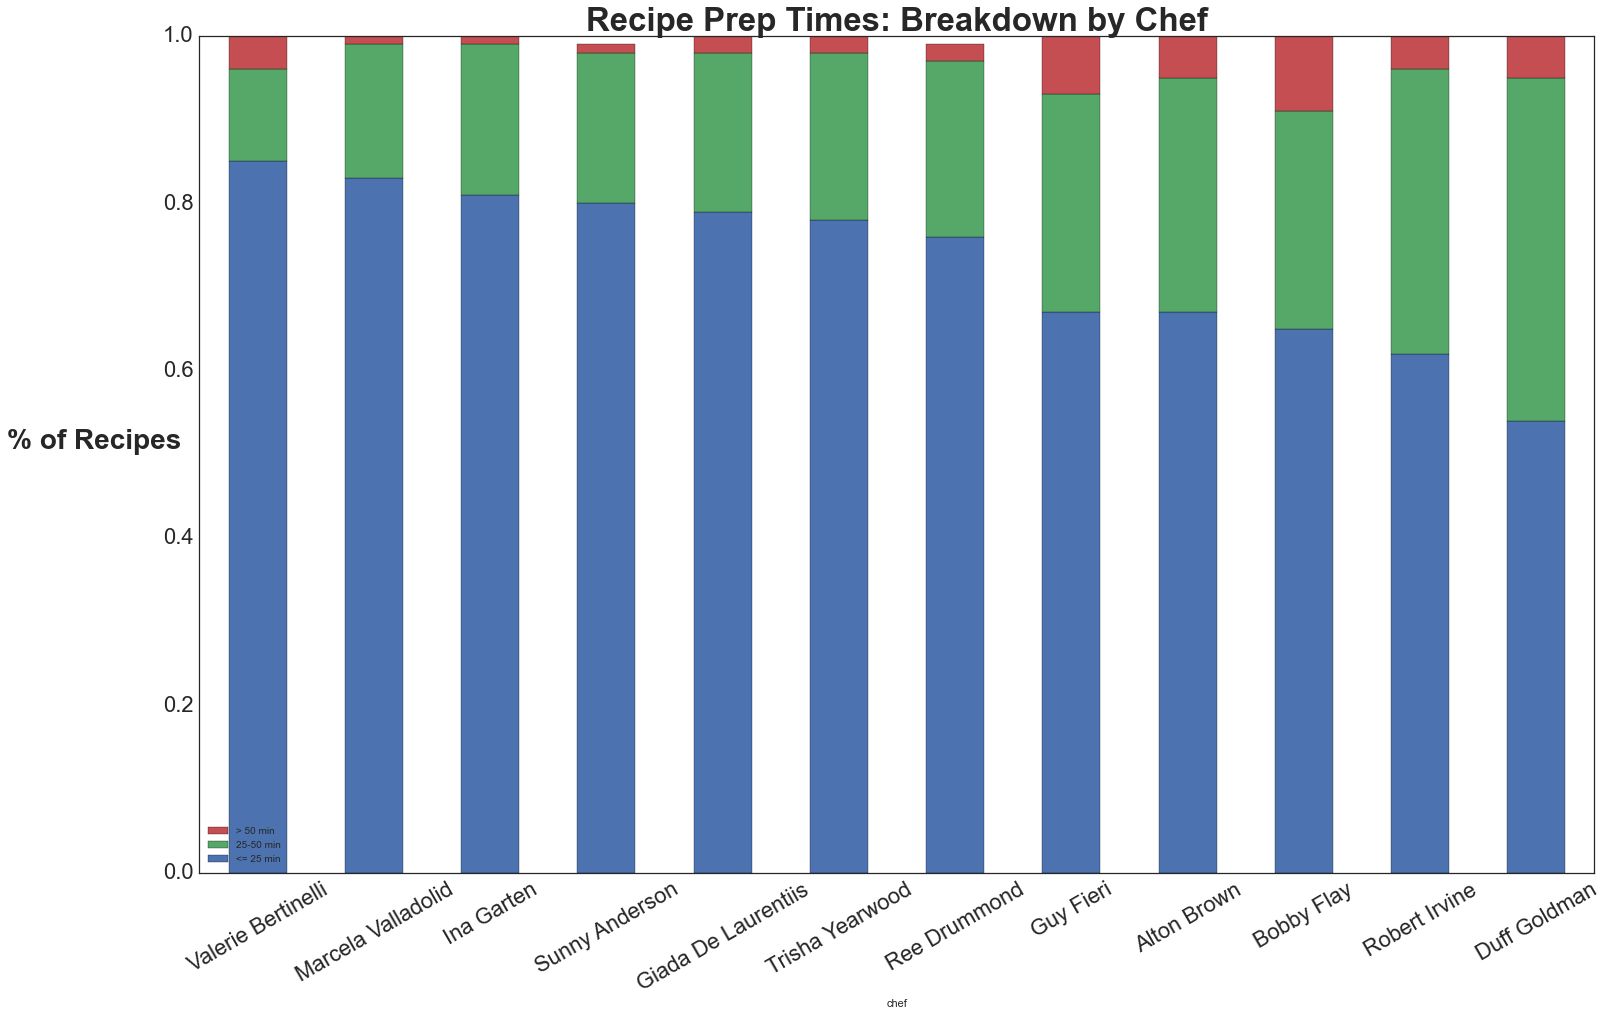

In [109]:
prep_df = pd.DataFrame()
prep_df['chef'] = chefs_prep
prep_df['<= 25 min'] = prep_low
prep_df['25-50 min'] = prep_mid
prep_df['> 50 min'] = prep_high
prep_df = prep_df.set_index('chef')
prep_df.plot.bar(figsize=(25, 15), stacked=True, ylim=(0,1), fontsize=22, sort_columns=True,
                 rot=30, legend='reverse')
axisfont = {'weight' : 'bold',
        'size'   : 28}
titlefont = {'weight' : 'bold',
        'size'   : 33}
plt.ylabel('% of Recipes', rotation=0, labelpad=70, **axisfont)
plt.title('Recipe Prep Times: Breakdown by Chef', **titlefont)

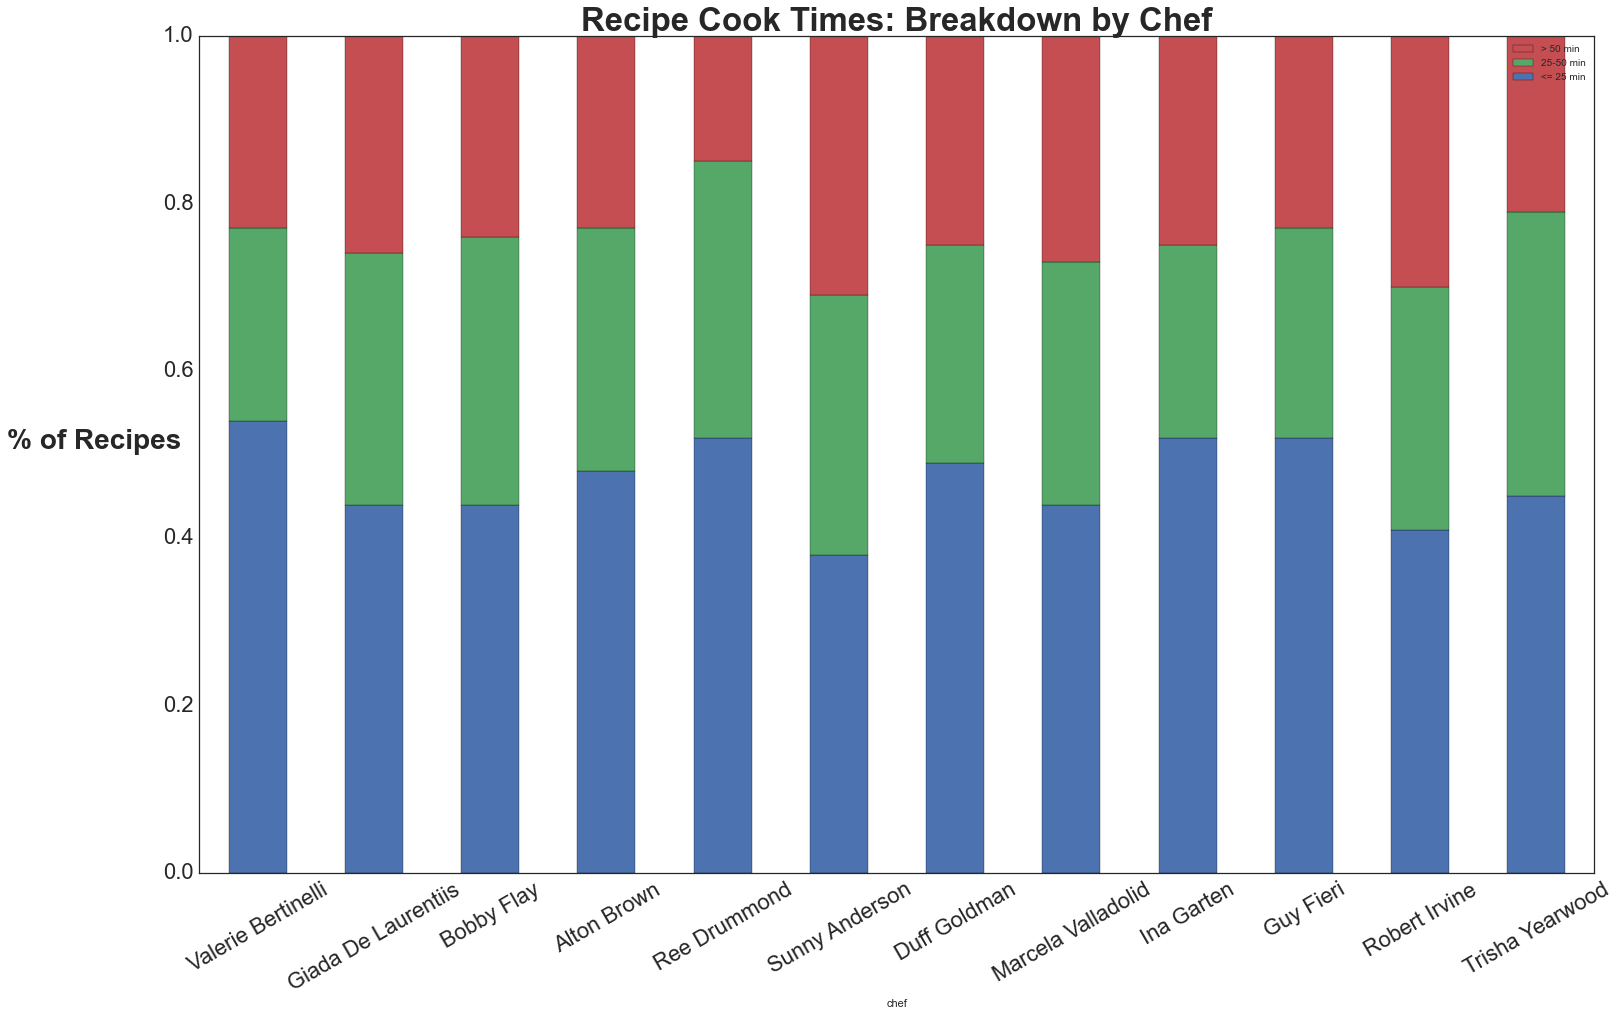

In [111]:
cook_df = pd.DataFrame()
cook_df['chef'] = chefs_cook
cook_df['<= 25 min'] = cook_low
cook_df['25-50 min'] = cook_mid
cook_df['> 50 min'] = cook_high
cook_df = cook_df.set_index('chef')
cook_df.plot.bar(figsize=(25, 15), stacked=True, ylim=(0,1), fontsize=22, sort_columns=True,
                 rot=30, legend='reverse')
axisfont = {'weight' : 'bold',
        'size'   : 28}
titlefont = {'weight' : 'bold',
        'size'   : 33}
plt.ylabel('% of Recipes', rotation=0, labelpad=70, **axisfont)
plt.title('Recipe Cook Times: Breakdown by Chef', **titlefont)

**Duration Variance Score (DVS)**

Prep time DVS:

In [193]:
print 'Recipe prep times: variability by chef'
for chef, stats in durations_by_chef_totals.items():
    if stats['prep_time_variance'] < 100:
        print chef, 'very low'
    elif stats['prep_time_variance'] < 134:
        print chef, 'low'
    elif stats['prep_time_variance'] < 167:
        print chef, 'medium'
    elif stats['prep_time_variance'] < 200:
        print chef, 'high'
    else:
        print chef, 'very high'

Recipe prep times: variability by chef
Giada De Laurentiis medium
Alton Brown high
Trisha Yearwood medium
Guy Fieri very high
Valerie Bertinelli very low
Marcela Valladolid very low
Ina Garten low
Ree Drummond low
Bobby Flay very high
Robert Irvine medium
Sunny Anderson low
Duff Goldman high


Inactive time DVS:

In [214]:
print 'Recipe inactive times: variability by chef'
for chef, stats in durations_by_chef_totals.items():
    if stats['inactive_time_variance'] < 10000:
        print chef, 'very low'
    elif stats['inactive_time_variance'] < 14000:
        print chef, 'low'
    elif stats['inactive_time_variance'] < 19000:
        print chef, 'medium'
    elif stats['inactive_time_variance'] < 23000:
        print chef, 'high'
    else:
        print chef, 'very high'

Recipe inactive times: variability by chef
Giada De Laurentiis low
Alton Brown very high
Trisha Yearwood medium
Guy Fieri high
Valerie Bertinelli very low
Marcela Valladolid low
Ina Garten very high
Ree Drummond high
Bobby Flay medium
Robert Irvine very low
Sunny Anderson medium
Duff Goldman low


Cook time DVS:

In [226]:
print 'Recipe cook times: variability by chef'
for chef, stats in durations_by_chef_totals.items():
    if stats['cook_time_variance'] < 700:
        print chef, 'very low'
    elif stats['cook_time_variance'] < 850:
        print chef, 'low'
    elif stats['cook_time_variance'] < 1000:
        print chef, 'medium'
    elif stats['cook_time_variance'] < 1150:
        print chef, 'high'
    else:
        print chef, 'very high'

Recipe cook times: variability by chef
Giada De Laurentiis very low
Alton Brown very high
Trisha Yearwood low
Guy Fieri high
Valerie Bertinelli low
Marcela Valladolid high
Ina Garten medium
Ree Drummond medium
Bobby Flay very high
Robert Irvine medium
Sunny Anderson medium
Duff Goldman very low


Total time DVS:

In [188]:
print 'Recipe total durations: variability by chef'

for chef, stats in durations_by_chef_totals.items():
    if stats['total_time_variance'] < 6000:
        print chef, 'very low'
    elif stats['total_time_variance'] < 7500:
        print chef, 'low'
    elif stats['total_time_variance'] < 9000:
        print chef, 'medium'
    elif stats['total_time_variance'] < 10500:
        print chef, 'high'
    else:
        print chef, 'very high'

Recipe total durations: variability by chef
Giada De Laurentiis low
Alton Brown very high
Trisha Yearwood high
Guy Fieri low
Valerie Bertinelli high
Marcela Valladolid very low
Ina Garten medium
Ree Drummond high
Bobby Flay high
Robert Irvine low
Sunny Anderson low
Duff Goldman very high
